# **🕵🏻 Agentic RAG with 🦙 Llama 3.2 3B**
  <img src="https://img-cdn.inc.com/image/upload/w_1280,ar_16:9,c_fill,g_auto,q_auto:best/images/panoramic/meta-llama3-inc_539927_dhgoal.webp" width="310"/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://haystack.deepset.ai/images/haystack-ogimage.png" width="350" style="display:inline;">
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<img src="https://upload.wikimedia.org/wikipedia/en/thumb/8/88/DuckDuckGo_logo.svg/800px-DuckDuckGo_logo.svg.png" width="230" style="display:inline;">

In their [Llama 3.2 collection](https://ai.meta.com/blog/llama-3-2-connect-2024-vision-edge-mobile-devices/), Meta released two small yet powerful Language Models.

In this notebook, we'll use the 3B model to build an **Agentic Retrieval Augmented Generation application**.

🎯 Our goal is to create a system that answers questions using a knowledge base focused on the Seven Wonders of the Ancient World. If the retrieved documents don't contain the answer, the application will fall back to web search for additional context.

Stack:
- 🏗️ [Haystack](https://haystack.deepset.ai/): open-source LLM orchestration framework that streamlines the development of your LLM applications.

- 🦙 [Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct): small and good Language Model.

- 🦆🌐 [DuckDuckGo API Websearch](https://haystack.deepset.ai/integrations/duckduckgo-api-websearch) to search results on the Web.


## Setup

In [ ]:
! pip install haystack-ai duckduckgo-api-haystack transformers sentence-transformers datasets

## Create our knowledge base

In this section, we download a dataset on the Seven Wonders of the Ancient World, enrich each document with a semantic vector and store the documents in an in-memory database.

To better understand this process, you can explore to the [introductory Haystack tutorial](https://haystack.deepset.ai/tutorials/27_first_rag_pipeline).

In [ ]:
from datasets import load_dataset
from haystack import Document

from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

document_store = InMemoryDocumentStore()

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset]

doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
doc_embedder.warm_up()

docs_with_embeddings = doc_embedder.run(docs)
document_store.write_documents(docs_with_embeddings["documents"])




/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

151

## Load and try Llama 3.2

We will use Hugging Face Transformers to load the model on a Colab.

There are plenty of other options to use open models on Haystack, including for example [Ollama](https://haystack.deepset.ai/integrations/ollama) for local inference or serving with [Groq](https://haystack.deepset.ai/integrations/groq).

\([📕 Choosing the Right Generator](https://docs.haystack.deepset.ai/docs/choosing-the-right-generator)\).


**Authorization**
- you need an Hugging Face account
- you need to accept Meta conditions here: https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct and wait for the authorization

In [ ]:
import getpass, os

os.environ["HF_TOKEN"] = getpass.getpass("Your Hugging Face token")

Your Hugging Face token··········


In [ ]:
import torch
from haystack.components.generators import HuggingFaceLocalGenerator

generator = HuggingFaceLocalGenerator(
    model="meta-llama/Llama-3.2-3B-Instruct",
    huggingface_pipeline_kwargs={"device_map":"auto",
                                 "torch_dtype":torch.bfloat16},
    generation_kwargs={"max_new_tokens": 256})

generator.warm_up()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
prompt = """<|begin_of_text|><|start_header_id|>user<|end_header_id|>
  What is the capital of France?<|eot_id|>
  <|start_header_id|>assistant<|end_header_id|>"""

generator.run(prompt)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


{'replies': ['\n\nThe capital of France is Paris.']}

## Build the 🕵🏻 Agentic RAG Pipeline

Here's the idea 👇
- Perform a vector search on our knowledge base using the query.
- Pass the top 5 documents to Llama, injected in a specific prompt
- In the prompt, instruct the model to reply with "no_answer" if it cannot infer the answer from the documents; otherwise, provide the answer.
- If "no_answer" is returned, run a web search and inject the results into a new prompt.
- Let Llama generate a final answer based on the web search results.

For a detailed explanation of a similar use case, take a look at [this tutorial: Building Fallbacks to Websearch with Conditional Routing](https://haystack.deepset.ai/tutorials/36_building_fallbacks_with_conditional_routing).

### Retrieval part

Let's initialize the components to use for the initial retrieval phase.

In [ ]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store, top_k=5)

### Prompt template

Let's define the first prompt template, which instructs the model to:
- answer the query based on the retrieved documents, if possible
- reply with 'no_answer', otherwise

In [ ]:
from haystack.components.builders import PromptBuilder

prompt_template = """
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Answer the following query given the documents.
If the answer is not contained within the documents reply with 'no_answer'.
If the answer is contained within the documents, start the answer with "FROM THE KNOWLEDGE BASE: ".

Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}

Query: {{query}}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

prompt_builder = PromptBuilder(template=prompt_template)

### Conditional Router

This is the component that will perform data routing, depending on the reply given by the Language Model.

In [ ]:
from haystack.components.routers import ConditionalRouter

routes = [
    {
        "condition": "{{'no_answer' in replies[0]}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch",
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

router = ConditionalRouter(routes)

In [ ]:
router.run(replies=["this is the answer!"])

{'answer': 'this is the answer!'}

In [ ]:
router.run(replies=["no_answer"], query="my query")

{'go_to_websearch': 'my query'}

### Web search

In [ ]:
from duckduckgo_api_haystack import DuckduckgoApiWebSearch

websearch = DuckduckgoApiWebSearch(top_k=5)

In [ ]:
# Perform a search
results = websearch.run(query="Where is Tanzania?")

# Access the search results
documents = results["documents"]
links = results["links"]

print("Found documents:")
for doc in documents:
    print(f"Content: {doc.content}")

print("\nSearch Links:")
for link in links:
    print(link)

Found documents:
Content: Tanzania is a country in East Africa within the African Great Lakes region. It is bordered by Uganda, Kenya, the Indian Ocean, Mozambique, Malawi, Zambia, Rwanda, Burundi, and the Democratic Republic of the Congo.
Content: Tanzania is a country in East Africa's Great Lakes Region, located just below the Equator. It is bordered by eight countries and the Indian Ocean, and has diverse geographical features such as mountains, lakes, rivers, and islands.
Content: Tanzania is an East African country formed by the union of Tanganyika and Zanzibar in 1964. It has diverse landscapes, including Mount Kilimanjaro, Lake Victoria, and the Great Rift Valley, and a rich cultural heritage.
Content: Tanzania is the largest and most populous country in East Africa, with a total area of 947,300 sq km and a coastline of 1,424 km. It has diverse natural features, including mountains, lakes, rivers, and islands, and borders eight other countries.
Content: Tanzania is a country in 

### Prompt template after Web search

In [ ]:
prompt_template_after_websearch = """
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Answer the following query given the documents retrieved from the web.
Start the answer with "FROM THE WEB: ".

Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}

Query: {{query}}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

prompt_builder_after_websearch = PromptBuilder(template=prompt_template_after_websearch)

### Assembling the Pipeline

Now that we have all the components, we can assemble the full pipeline.

To handle the different prompt sources, we'll use a [`BranchJoiner`](https://docs.haystack.deepset.ai/docs/branchjoiner). This allows us to connect multiple output sockets (with prompts) to our language model. In our case, the prompt will either come from the initial `prompt_builder` or from `prompt_builder_after_websearch`.

In [ ]:
from haystack.components.joiners import BranchJoiner
prompt_joiner  = BranchJoiner(str)

from haystack import Pipeline

pipe = Pipeline()
pipe.add_component("text_embedder", text_embedder)
pipe.add_component("retriever", retriever)
pipe.add_component("prompt_builder", prompt_builder)
pipe.add_component("prompt_joiner", prompt_joiner)
pipe.add_component("llm", generator)
pipe.add_component("router", router)
pipe.add_component("websearch", websearch)
pipe.add_component("prompt_builder_after_websearch", prompt_builder_after_websearch)

pipe.connect("text_embedder", "retriever")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "prompt_joiner")
pipe.connect("prompt_joiner", "llm")
pipe.connect("llm.replies", "router.replies")
pipe.connect("router.go_to_websearch", "websearch.query")
pipe.connect("router.go_to_websearch", "prompt_builder_after_websearch.query")
pipe.connect("websearch.documents", "prompt_builder_after_websearch.documents")
pipe.connect("prompt_builder_after_websearch", "prompt_joiner")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - prompt_joiner: BranchJoiner
  - llm: HuggingFaceLocalGenerator
  - router: ConditionalRouter
  - websearch: DuckduckgoApiWebSearch
  - prompt_builder_after_websearch: PromptBuilder
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> prompt_joiner.value (str)
  - prompt_joiner.value -> llm.prompt (str)
  - llm.replies -> router.replies (List[str])
  - router.go_to_websearch -> websearch.query (str)
  - router.go_to_websearch -> prompt_builder_after_websearch.query (str)
  - websearch.documents -> prompt_builder_after_websearch.documents (List[Document])
  - prompt_builder_after_websearch.prompt -> prompt_joiner.value (str)

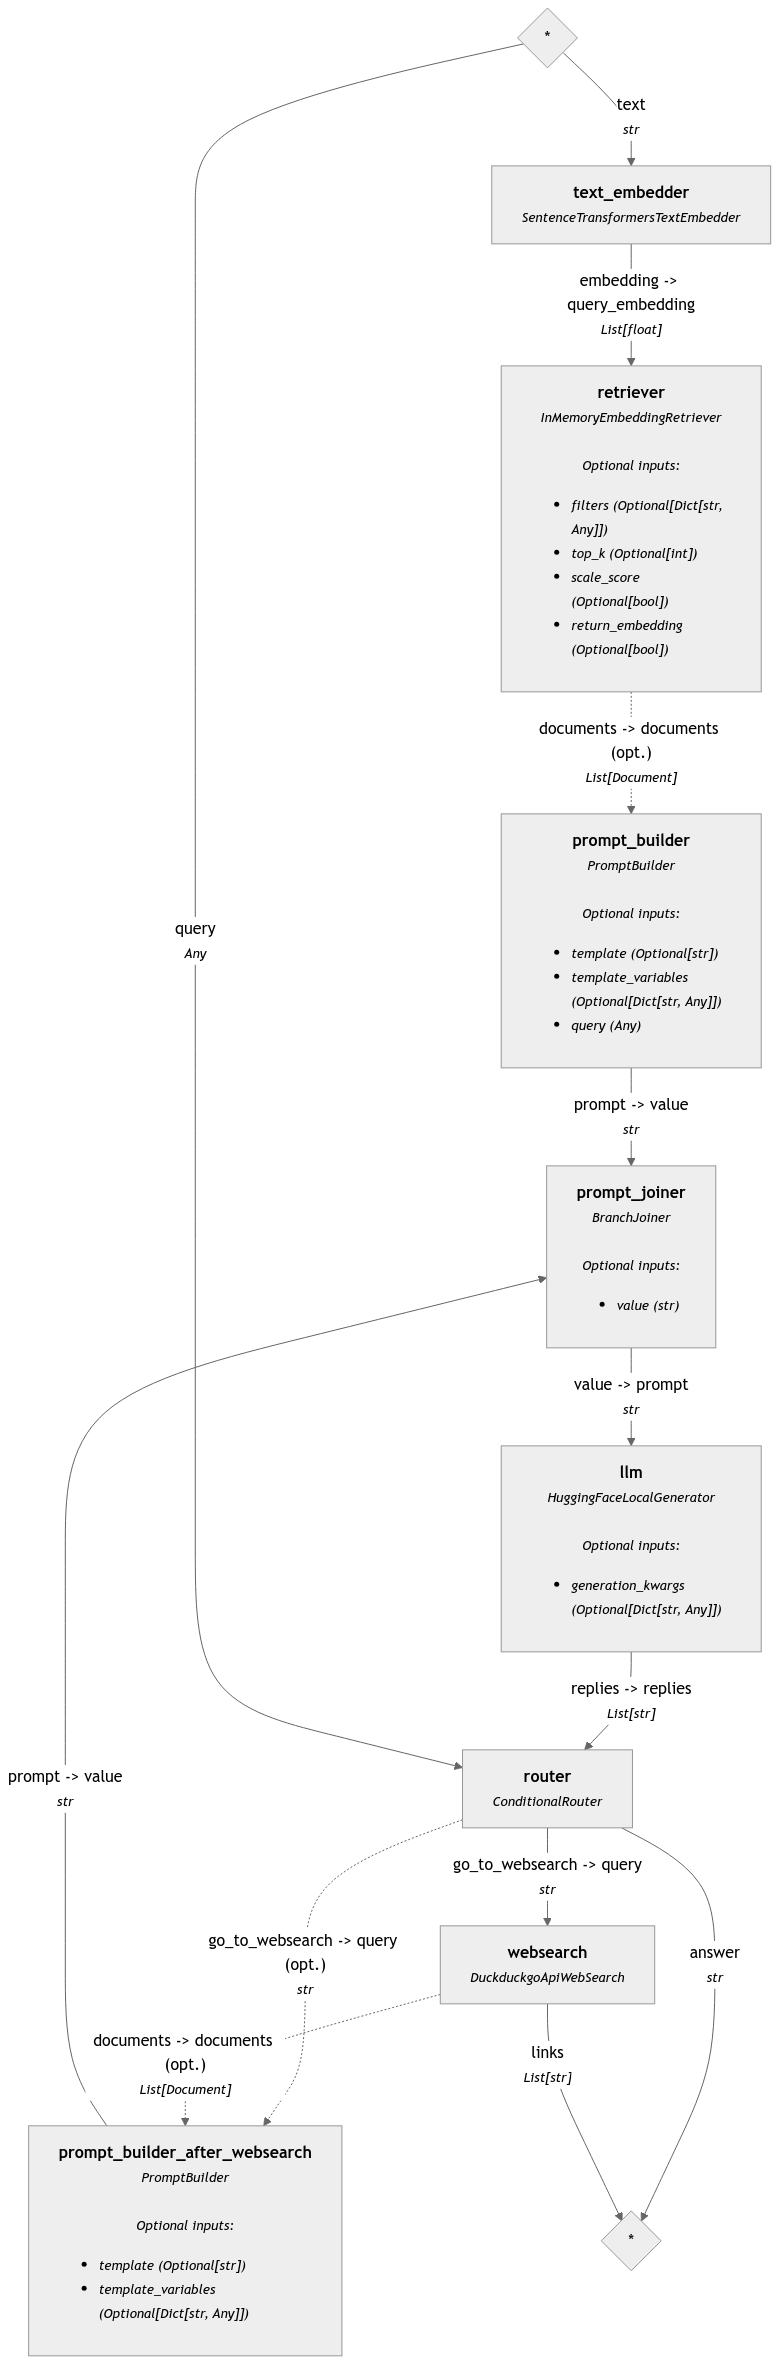

In [ ]:
pipe.show()

## Agentic RAG in action! 🔎

In [ ]:
def get_answer(query):
  result = pipe.run({"text_embedder": {"text": query}, "prompt_builder": {"query": query}, "router": {"query": query}})
  print(result["router"]["answer"])

In [ ]:
query = "Why did people build Great Pyramid of Giza?"

get_answer(query)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




FROM THE KNOWLEDGE BASE: The Great Pyramid of Giza was built as the tomb of Fourth Dynasty pharaoh Khufu, and its construction is believed to have taken around 27 years to complete.


In [ ]:
query = "Where is Munich?"

get_answer(query)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




FROM THE WEB: Munich is located in the south of Germany, and is the capital of the federal state of Bavaria. It is connected to other major cities in Germany and Austria, and has direct access to Italy.


In [ ]:
query = "What does Rhodes Statue look like?"

get_answer(query)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




FROM THE KNOWLEDGE BASE: The head of the Colossus of Rhodes was of a standard rendering at the time, with curly hair and evenly spaced spikes of bronze or silver flame radiating from it, similar to the images found on contemporary Rhodian coins.


In [ ]:
query = "Was the the Tower of Pisa part of the 7 wonders of the ancient world?"

get_answer(query)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




FROM THE WEB: No, the Leaning Tower of Pisa was one of the Seven Wonders of the Medieval World, but not of the ancient world.


In [ ]:
query = "Who was general Muawiyah?"

get_answer(query)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.




FROM THE KNOWLEDGE BASE: Muawiyah I was a Muslim general who conquered Rhodes in 653.


*(Notebook by [Stefano Fiorucci](https://github.com/anakin87))*